# Loan Default Prediction 
SuperLender is a local digital lending company. SuperLender wants to build machine learning model to lower the risk of loan default and deliver profitable and high-impact loan alternative. Now, try to predict if a loan was good or bad. This is binary classification business problem, where Good is 1 and Bad is 0.
Source : https://zindi.africa/competitions/data-science-nigeria-challenge-1-loan-default-prediction

We are not given the relative impact of false negatives (versus other outcomes). You are free to make your own assumptions.

#Columns, Description 

## **a) Demographic data (traindemographics.csv)**
- **customerid** (Primary key used to merge to other data)
- **birthdate** (date of birth of the customer)
- **bank_account_type** (type of primary bank account)
- **longitude_gps**
- **latitude_gps**
- **bank_name_clients** (name of the bank)
- **bank_branch_clients** (location of the branch - not compulsory - so missing in a lot of the cases)
- **employment_status_clients** (type of employment that customer has)
- **level_of_education_clients** (highest level of education)

## **b) Performance data (trainperf.csv)**
- **customerid** (Primary key used to merge to other data)
-**systemloanid** (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- **loannumber** (The number of the loan that you have to predict)
- **approveddate** (Date that loan was approved)
- **creationdate** (Date that loan application was created)
- **loanamount** (Loan value taken)
- **totaldue** (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- **termdays** (Term of loan)
- **referredby** (customerId of the customer that referred this person - is missing, then not referred)
- **good_bad_flag** (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predict


In [ ]:
# Basic Libraries
import pandas as pd
import seaborn as sns

import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats.mstats import winsorize
import scipy.stats as ss
import math
import seaborn as sns
from datetime import datetime

In [ ]:
# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV


In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

# **Read Dataset**

In [ ]:
# Read two files 
file_1 = "trainperf.csv"   # adapt this as needed to the file structure on your Google drive
df1 = pd.read_csv(file_1) # read in csv file

file_2= "traindemographics.csv"   
df2 = pd.read_csv(file_2) # read in csv file

In [ ]:
# Merge two files using inner join
result = pd.merge(df1, df2, how='inner', on='customerid')

# **EDA**

In [ ]:
result.tail()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
3272,8a858e395cb1d4d9015cb2115b1d13d7,301964335,2,2017-07-05 08:23:02.000000,2017-07-05 07:22:56.000000,10000.0,11500.0,15,8a858eb75c21a2b9015c29ebece12d01,Bad,1979-03-22 00:00:00.000000,Savings,3.302387,6.568690,GT Bank,NaN,NaN,NaN
3273,8a858ee85cf400f5015cf44ab1c42d5c,301998967,2,2017-07-27 15:35:47.000000,2017-07-27 14:35:40.000000,10000.0,13000.0,30,NaN,Bad,1989-12-04 00:00:00.000000,Savings,4.607358,8.460608,FCMB,NaN,Permanent,NaN
3274,8a858f365b2547f3015b284597147c94,301995576,3,2017-07-25 16:25:57.000000,2017-07-25 15:24:47.000000,10000.0,11500.0,15,NaN,Bad,1989-11-21 00:00:00.000000,Savings,3.976842,7.409129,First Bank,NaN,Permanent,NaN
3275,8a858f935ca09667015ca0ee3bc63f51,301977679,2,2017-07-14 13:50:27.000000,2017-07-14 12:50:21.000000,10000.0,13000.0,30,8a858eda5c8863ff015c9dead65807bb,Bad,1990-06-11 00:00:00.000000,Savings,3.986089,7.386796,Skye Bank,NaN,Permanent,NaN
3276,8a858fd458639fcc015868eb14b542ad,301967124,8,2017-07-06 21:01:06.000000,2017-07-06 20:01:01.000000,30000.0,34500.0,30,NaN,Bad,1988-08-16 00:00:00.000000,Savings,3.725655,6.474430,GT Bank,NaN,NaN,NaN


In [ ]:
# customer ID and System ID are deleted, as they don't add information to the model
# bank_branch_clients is deleted to reduce the # of features after encoding
# approveddate and creationdate are deleted, as they don't add much value 
result = result.drop(columns=['customerid', 'systemloanid','bank_branch_clients','approveddate','creationdate'])

In [ ]:
# Shape of df
print("Shape", result.shape)

# Check data types
print(result.info())

Shape (3277, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3277 entries, 0 to 3276
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loannumber                  3277 non-null   int64  
 1   loanamount                  3277 non-null   float64
 2   totaldue                    3277 non-null   float64
 3   termdays                    3277 non-null   int64  
 4   referredby                  450 non-null    object 
 5   good_bad_flag               3277 non-null   object 
 6   birthdate                   3277 non-null   object 
 7   bank_account_type           3277 non-null   object 
 8   longitude_gps               3277 non-null   float64
 9   latitude_gps                3277 non-null   float64
 10  bank_name_clients           3277 non-null   object 
 11  employment_status_clients   2784 non-null   object 
 12  level_of_education_clients  443 non-null    object 
dtypes: float64(4), i

In [ ]:
# Describe Dataset 
print("\n DESCRIBE\n",result.describe())


 DESCRIBE
         loannumber    loanamount      totaldue     termdays  longitude_gps  \
count  3277.000000   3277.000000   3277.000000  3277.000000    3277.000000   
mean      5.185536  17830.332621  21280.569271    29.258468       4.534611   
std       3.665967  10742.059352  11929.316405    11.405342       7.916626   
min       2.000000  10000.000000  10000.000000    15.000000    -118.247009   
25%       2.000000  10000.000000  13000.000000    30.000000       3.354984   
50%       4.000000  10000.000000  13000.000000    30.000000       3.587546   
75%       7.000000  20000.000000  24500.000000    30.000000       6.478157   
max      27.000000  60000.000000  68100.000000    90.000000     151.209290   

       latitude_gps  
count   3277.000000  
mean       7.292799  
std        3.268758  
min      -33.868818  
25%        6.473645  
50%        6.625954  
75%        7.429882  
max       71.228069  


In [ ]:
# Check Skewness
print("\n SKEWNESS\n",result.skew())


 SKEWNESS
 loannumber       1.320175
loanamount       1.241791
totaldue         1.154553
termdays         1.875509
longitude_gps   -3.211137
latitude_gps     9.342461
dtype: float64


C:\Users\bodhy\AppData\Local\Temp/ipykernel_3152/3473527760.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print("\n SKEWNESS\n",result.skew())


In [ ]:
# Check Skewness
print("\n kurtosis\n",result.kurtosis())


 kurtosis
 loannumber         1.530788
loanamount         0.620163
totaldue           0.283694
termdays           6.226940
longitude_gps    166.777991
latitude_gps     143.510897
dtype: float64


C:\Users\bodhy\AppData\Local\Temp/ipykernel_3152/3149461962.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print("\n kurtosis\n",result.kurtosis())


CORRELATION MATRIX
                loannumber  loanamount  totaldue  termdays  longitude_gps  \
loannumber       1.000000    0.834935  0.816444  0.398729      -0.007593   
loanamount       0.834935    1.000000  0.994311  0.551188      -0.001301   
totaldue         0.816444    0.994311  1.000000  0.621356      -0.001766   
termdays         0.398729    0.551188  0.621356  1.000000       0.003204   
longitude_gps   -0.007593   -0.001301 -0.001766  0.003204       1.000000   
latitude_gps    -0.000543    0.010006  0.007852 -0.008003      -0.253237   

               latitude_gps  
loannumber        -0.000543  
loanamount         0.010006  
totaldue           0.007852  
termdays          -0.008003  
longitude_gps     -0.253237  
latitude_gps       1.000000  





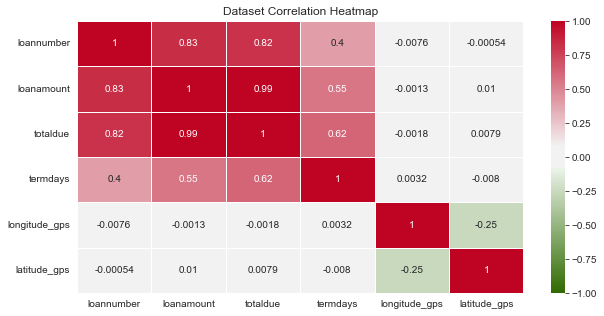



COVARIANCE MATRIX
                  loannumber    loanamount      totaldue      termdays  \
loannumber        13.439315  3.287978e+04  3.570513e+04     16.671505   
loanamount     32879.779538  1.153918e+08  1.274164e+08  67529.825479   
totaldue       35705.125666  1.274164e+08  1.423086e+08  84540.430503   
termdays          16.671505  6.752983e+04  8.454043e+04    130.081831   
longitude_gps     -0.220354 -1.106766e+02 -1.668021e+02      0.289317   
latitude_gps      -0.006512  3.513529e+02  3.061624e+02     -0.298350   

               longitude_gps  latitude_gps  
loannumber         -0.220354     -0.006512  
loanamount       -110.676598    351.352890  
totaldue         -166.802134    306.162404  
termdays            0.289317     -0.298350  
longitude_gps      62.672963     -6.553162  
latitude_gps       -6.553162     10.684782  





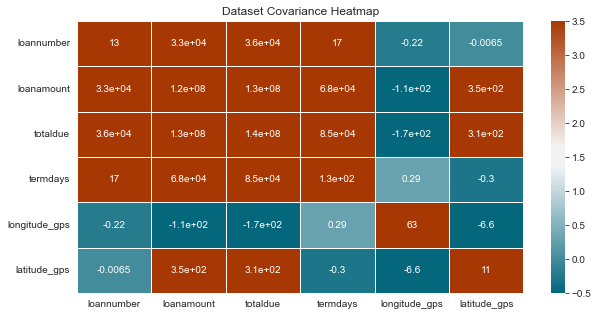

In [ ]:
# Multivariate numerical descriptive statistics

#Correlation Matrix
print("CORRELATION MATRIX\n",result.corr())
print("\n\n")

#Correlation Matrix as a Heatmap
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
cmap = sns.diverging_palette(120, 10, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True) 
sns.heatmap((result).corr(), vmin = -1, vmax = 1, annot = True, cmap = cmap, lw = .5, linecolor = 'white')
plt.title("Dataset Correlation Heatmap")
plt.show()

# Covariance Matrix
print("\n\nCOVARIANCE MATRIX\n",result.cov())
print("\n\n")

#Covariance Matrix as a Heatmap
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
cmap = sns.diverging_palette(220, 20, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True) 
sns.heatmap((result).cov(), vmin = -0.5, vmax = 3.5, annot = True, cmap = cmap, lw = .5, linecolor = 'white')
plt.title("Dataset Covariance Heatmap")
plt.show()

#**Encoding**

In [ ]:
# Encode categorical target variable 
good_bad_flag_mapping = {'Good': 1,
                         'Bad' : 0}
result['good_bad_flag'] = result['good_bad_flag'].map(good_bad_flag_mapping)
print('Label-encoded good_bad_flag:\n',result,"\n\n")

Label-encoded good_bad_flag:
       loannumber  loanamount  totaldue  termdays  \
0             12     30000.0   34500.0        30   
1              2     15000.0   17250.0        30   
2              7     20000.0   22250.0        15   
3              3     10000.0   11500.0        15   
4              9     40000.0   44000.0        30   
...          ...         ...       ...       ...   
3272           2     10000.0   11500.0        15   
3273           2     10000.0   13000.0        30   
3274           3     10000.0   11500.0        15   
3275           2     10000.0   13000.0        30   
3276           8     30000.0   34500.0        30   

                            referredby  good_bad_flag  \
0                                  NaN              1   
1                                  NaN              1   
2                                  NaN              1   
3                                  NaN              1   
4                                  NaN              1   
...

1    2563
0     714
Name: good_bad_flag, dtype: int64

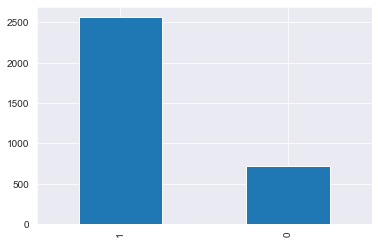

In [ ]:
# Count good and bad 
result["good_bad_flag"].value_counts().plot.bar()
result["good_bad_flag"].value_counts()

In [ ]:
# rename less frequent categories of bank_name_clients to 'Other'
need = result['bank_name_clients'].value_counts().index[:2]
result['bank_name_clients'] = np.where(result['bank_name_clients'].isin(need), result['bank_name_clients'], 'OTHER')

valCount = result['bank_name_clients'].value_counts()
print (valCount)

OTHER         1637
GT Bank       1210
First Bank     430
Name: bank_name_clients, dtype: int64


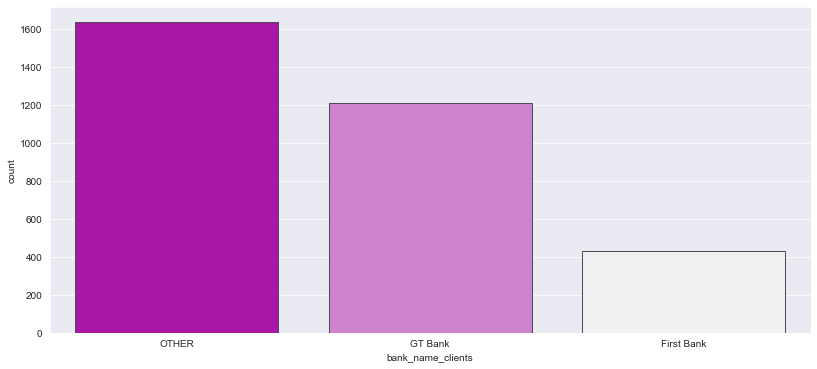

In [ ]:
# Univariate Bar Charts

plt.figure(figsize = (30,6))
plt.subplot(1,2,1)
sns.countplot(  x="bank_name_clients", data=result,palette="light:m_r",
    edgecolor=".3")
plt.show()

In [ ]:
# rename less frequent categories of employment_status_clients to 'Other'
need = result['employment_status_clients'].value_counts().index[:3]
result['employment_status_clients'] = np.where(result['employment_status_clients'].isin(need), result['employment_status_clients'], 'OTHER')

valCount = result['employment_status_clients'].value_counts()
print (valCount)

Permanent        2348
OTHER             541
Self-Employed     277
Student           111
Name: employment_status_clients, dtype: int64


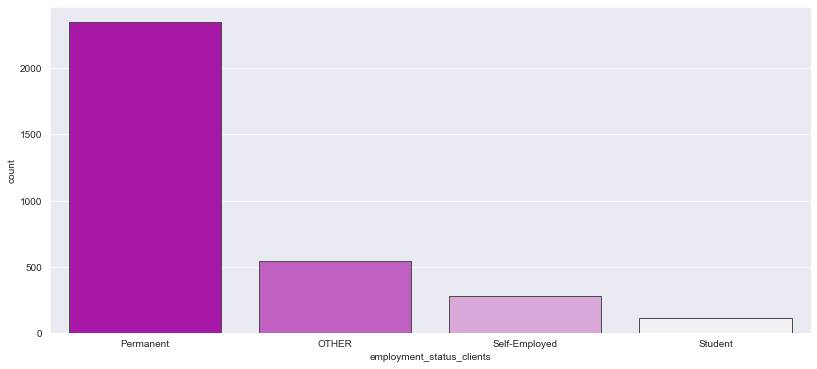

In [ ]:
# Univariate Bar Charts

plt.figure(figsize = (30,6))
plt.subplot(1,2,2)
sns.countplot(  x="employment_status_clients", data=result,palette="light:m_r",
    edgecolor=".3")
plt.show()

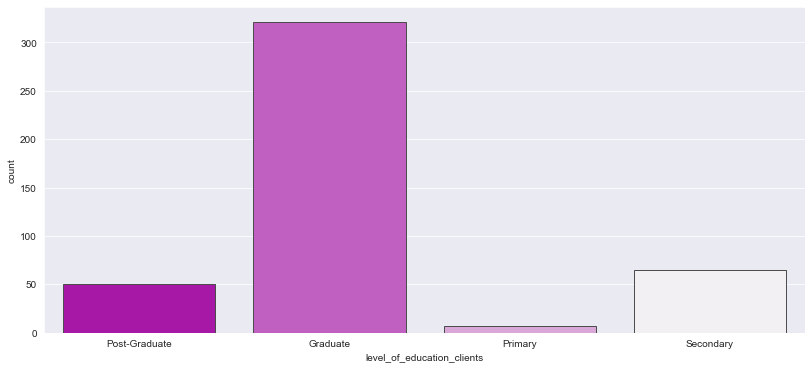

In [ ]:
# Univariate Bar Charts

plt.figure(figsize = (30,6))
plt.subplot(1,2,2)
sns.countplot(  x="level_of_education_clients", data=result,palette="light:m_r",
    edgecolor=".3")
plt.show()

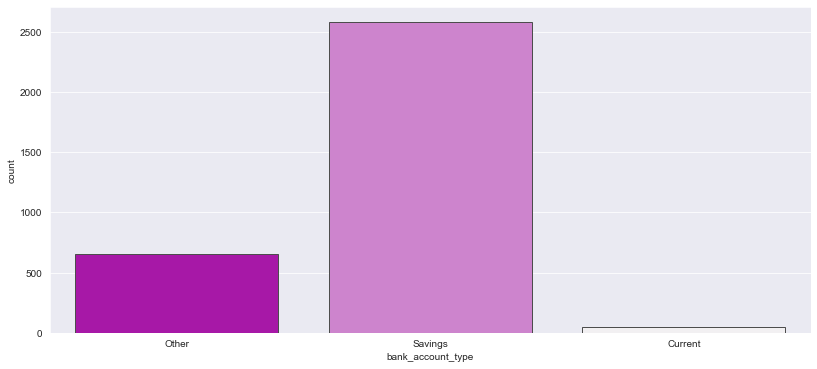

In [ ]:
# Univariate Bar Charts

plt.figure(figsize = (30,6))
plt.subplot(1,2,2)
sns.countplot(  x="bank_account_type", data=result,palette="light:m_r",
    edgecolor=".3")
plt.show()

In [ ]:
# change birthday to age. New column age is created
import pandas as pd
from datetime import datetime, date

  
# This function converts given date to age
def age(born):
    born = datetime.strptime(born, '%Y-%m-%d %H:%M:%S.%f').date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))
  
result['Age'] = result['birthdate'].apply(age)
  
display(result)

,loannumber,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients,level_of_education_clients,Age
0,12,30000.0,34500.0,30,NaN,1,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,OTHER,Permanent,Post-Graduate,50
1,2,15000.0,17250.0,30,NaN,1,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,Permanent,Graduate,36
2,7,20000.0,22250.0,15,NaN,1,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,OTHER,Permanent,NaN,37
3,3,10000.0,11500.0,15,NaN,1,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,Permanent,NaN,44
4,9,40000.0,44000.0,30,NaN,1,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,Permanent,Primary,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,2,10000.0,11500.0,15,8a858eb75c21a2b9015c29ebece12d01,0,1979-03-22 00:00:00.000000,Savings,3.302387,6.568690,GT Bank,OTHER,NaN,42
3273,2,10000.0,13000.0,30,NaN,0,1989-12-04 00:00:00.000000,Savings,4.607358,8.460608,OTHER,Permanent,NaN,32
3274,3,10000.0,11500.0,15,NaN,0,1989-11-21 00:00:00.000000,Savings,3.976842,7.409129,First Bank,Permanent,NaN,32
3275,2,10000.0,13000.0,30,8a858eda5c8863ff015c9dead65807bb,0,1990-06-11 00:00:00.000000,Savings,3.986089,7.386796,OTHER,Permanent,NaN,31


In [ ]:
# drop birthday
result = result.drop(columns=['birthdate'])

<AxesSubplot:xlabel='longitude_gps', ylabel='latitude_gps'>

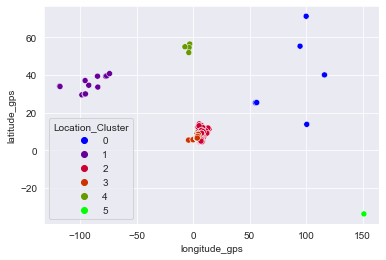

In [ ]:
# Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=6)
model.fit(result[['longitude_gps','latitude_gps']])
# assign a cluster to each example
yhat = pd.DataFrame(model.fit_predict(result[['longitude_gps','latitude_gps']]),columns=['Location_Cluster'])
if 'Location_Cluster' not in result:
  result = pd.concat([result,yhat],axis=1)
else:
  result['Location_Cluster'] = yhat
colors = ['#747FE3', '#8EE35D', '#E37346']
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x='longitude_gps', y='latitude_gps', data=result, hue='Location_Cluster', palette = "brg")

In [ ]:
# transform referredby variable to binary category 
# df["referredby"].fillna(np.nan, inplace = "No") 
for index, row in result.iterrows():
  if(pd.isnull(row['referredby'])):
    result['referredby'][index] = "No"
  else:
    result['referredby'][index] = "Yes"

C:\Users\bodhy\AppData\Local\Temp/ipykernel_3152/357908528.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['referredby'][index] = "No"
C:\Users\bodhy\AppData\Local\Temp/ipykernel_3152/357908528.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['referredby'][index] = "Yes"


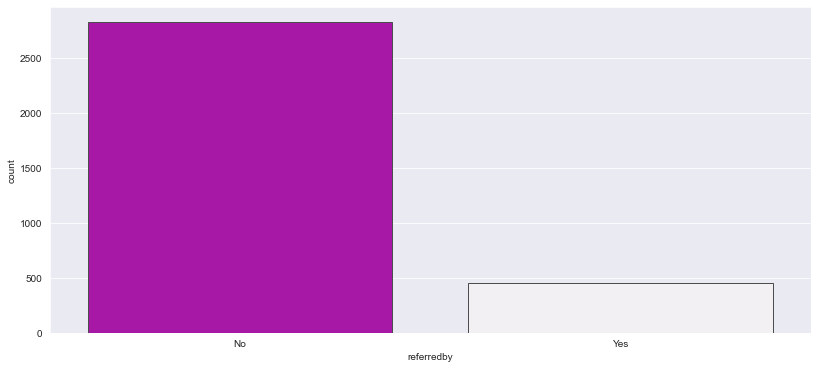

In [ ]:
# Univariate Bar Charts

plt.figure(figsize = (30,6))
plt.subplot(1,2,2)
sns.countplot(  x="referredby", data=result,palette="light:m_r",
    edgecolor=".3")
plt.show()

In [ ]:
# create dummy variables for categorical variables 
result = pd.get_dummies(data=result, columns=['referredby','bank_name_clients','employment_status_clients','bank_account_type','level_of_education_clients'])

In [ ]:
result

,loannumber,loanamount,totaldue,termdays,good_bad_flag,longitude_gps,latitude_gps,Age,Location_Cluster,referredby_No,...,employment_status_clients_Permanent,employment_status_clients_Self-Employed,employment_status_clients_Student,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,level_of_education_clients_Graduate,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary
0,12,30000.0,34500.0,30,1,3.432010,6.433055,50,3,1,...,1,0,0,0,1,0,0,1,0,0
1,2,15000.0,17250.0,30,1,3.885298,7.320700,36,3,1,...,1,0,0,0,0,1,1,0,0,0
2,7,20000.0,22250.0,15,1,11.139350,10.292041,37,2,1,...,1,0,0,0,1,0,0,0,0,0
3,3,10000.0,11500.0,15,1,3.985770,7.491708,44,3,1,...,1,0,0,0,0,1,0,0,0,0
4,9,40000.0,44000.0,30,1,7.457913,9.076574,35,2,1,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,2,10000.0,11500.0,15,0,3.302387,6.568690,42,3,0,...,0,0,0,0,0,1,0,0,0,0
3273,2,10000.0,13000.0,30,0,4.607358,8.460608,32,3,1,...,1,0,0,0,0,1,0,0,0,0
3274,3,10000.0,11500.0,15,0,3.976842,7.409129,32,3,1,...,1,0,0,0,0,1,0,0,0,0
3275,2,10000.0,13000.0,30,0,3.986089,7.386796,31,3,0,...,1,0,0,0,0,1,0,0,0,0


#**Visualizations**

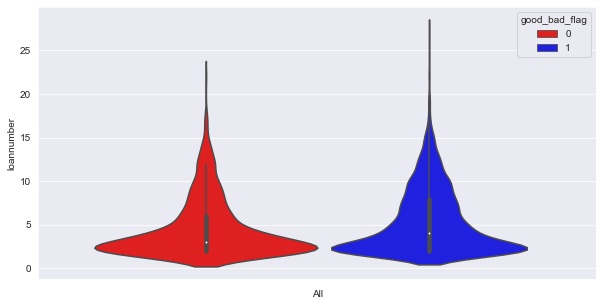

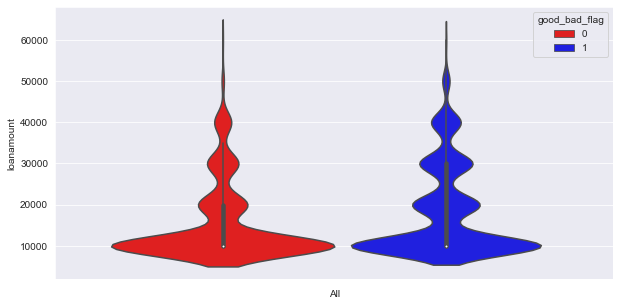

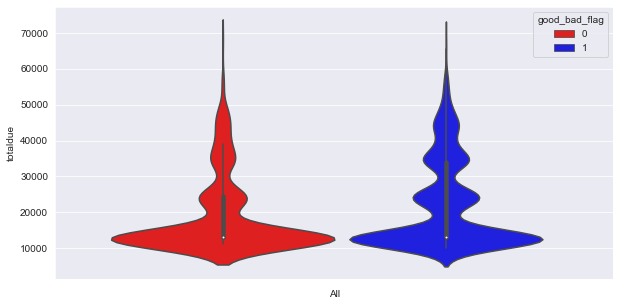

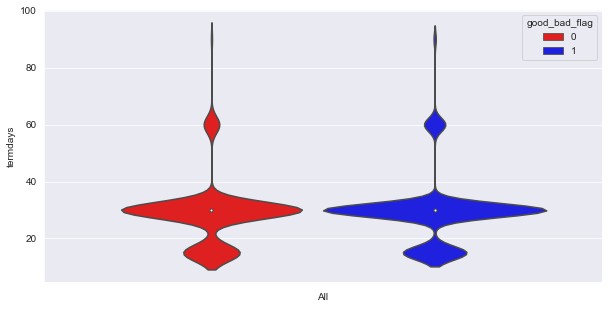

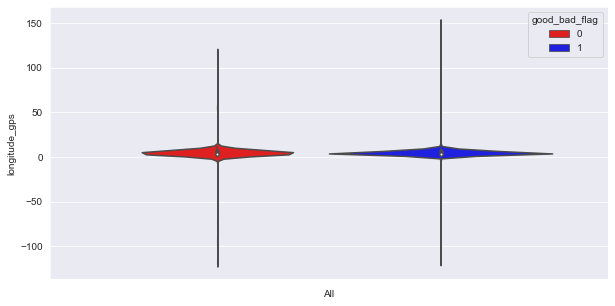

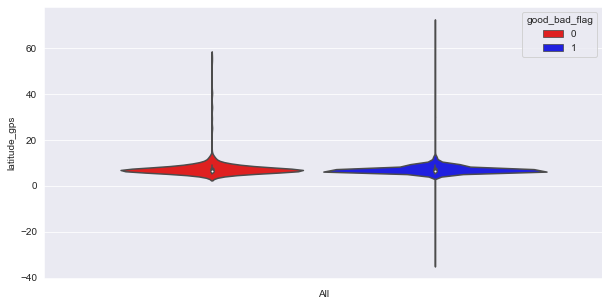

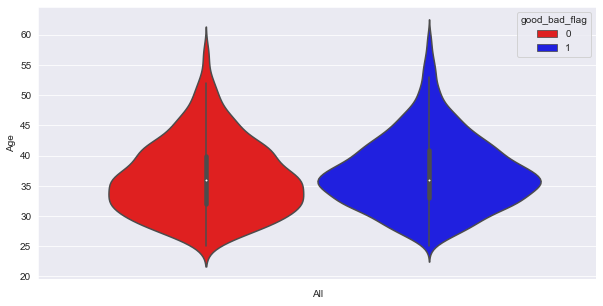

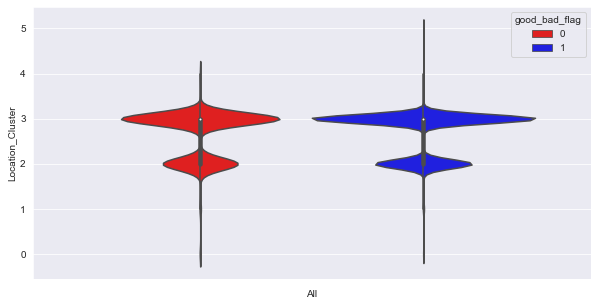

In [ ]:
# Violinplots for quant variables
result["All"] = ""
for i in result.columns:
  if (result.dtypes[i] == 'int64' or result.dtypes[i] == 'float64') and ((i != 'All') and (i != 'good_bad_flag')):
    plt.figure(figsize = (10,5))
    sns.violinplot(x = 'All',y = i, hue = "good_bad_flag", data = result,palette = {True:'blue', False:'red'})
    plt.show()
result.drop('All',axis=1)

result = result.drop(columns=['All'])

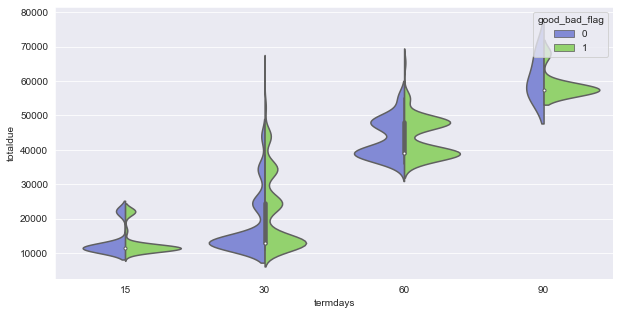

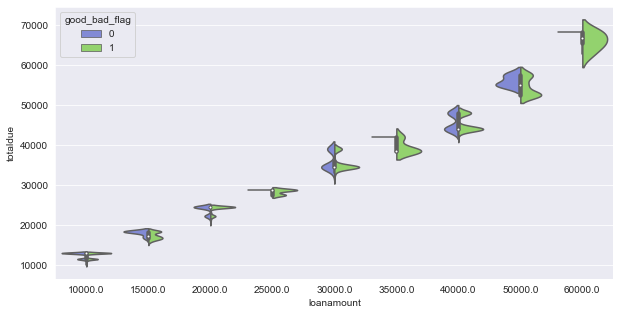

In [ ]:
# Bivariate violinplots
plt.figure(figsize = (10,5))
sns.violinplot(x ="termdays", y ="totaldue", hue ="good_bad_flag",data = result, split = True)
plt.show()
plt.figure(figsize = (10,5))
sns.violinplot(x ="loanamount", y ="totaldue", hue ="good_bad_flag",data = result, split = True)
plt.show()

# **Missing values & duplicates**

In [ ]:
# Count total NaN at each column in a DataFrame
print(" \nCount total NaN at each column in a DataFrame : \n\n",
      result.isnull().sum())

 
Count total NaN at each column in a DataFrame : 

 loannumber                                  0
loanamount                                  0
totaldue                                    0
termdays                                    0
good_bad_flag                               0
longitude_gps                               0
latitude_gps                                0
Age                                         0
Location_Cluster                            0
referredby_No                               0
referredby_Yes                              0
bank_name_clients_First Bank                0
bank_name_clients_GT Bank                   0
bank_name_clients_OTHER                     0
employment_status_clients_OTHER             0
employment_status_clients_Permanent         0
employment_status_clients_Self-Employed     0
employment_status_clients_Student           0
bank_account_type_Current                   0
bank_account_type_Other                     0
bank_account_type_Savings  

In [ ]:
result.isnull().any()

loannumber                                  False
loanamount                                  False
totaldue                                    False
termdays                                    False
good_bad_flag                               False
longitude_gps                               False
latitude_gps                                False
Age                                         False
Location_Cluster                            False
referredby_No                               False
referredby_Yes                              False
bank_name_clients_First Bank                False
bank_name_clients_GT Bank                   False
bank_name_clients_OTHER                     False
employment_status_clients_OTHER             False
employment_status_clients_Permanent         False
employment_status_clients_Self-Employed     False
employment_status_clients_Student           False
bank_account_type_Current                   False
bank_account_type_Other                     False


In [ ]:
# Check for duplicates and remove if there is any 
result.drop_duplicates(inplace = True)
print('\n Duplicates\n',result.duplicated().sum())


 Duplicates
 0


#**Pre-processing - Skewness correction**

In [ ]:
# pick numerical variables and set them as X
X = result[['loanamount','totaldue','termdays','loannumber','longitude_gps','latitude_gps','Age']]

In [ ]:
# Code for skewness correction (see source below)
# Depending upon the characteritics of a feature (column), a log, Box-Cox or power transform is applied to normalize the distribution 

# -*- coding: utf-8 -*-
"""
Created on Sat Feb 23 14:42:46 2019
@author: DATAmadness
"""

##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness

# Further documentation available here:
# https://datamadness.github.io/Skewness_Auto_Transform

def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go through desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            #ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1 = sns.histplot(DF[col], ax=axes[0], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
            ax1.set(xlabel='Original ' + str(col))
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                #ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2 = sns.histplot(DF[col], ax=axes[1], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='Transformed ' + str(col))
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                #ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2 = sns.histplot(DF[col], ax=axes[1], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='NO TRANSFORM ' + str(col))
                plt.show()
                

    return DF


 ------------------------------------------------------

 'loanamount' had 'positive' skewness of 1.24

 Transformation yielded skewness of 0.40


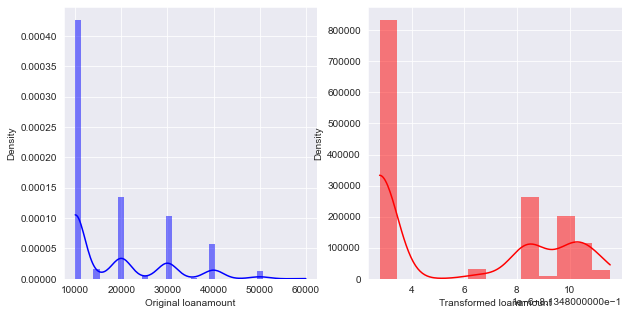


 ------------------------------------------------------

 'totaldue' had 'positive' skewness of 1.15

 Transformation yielded skewness of 0.34


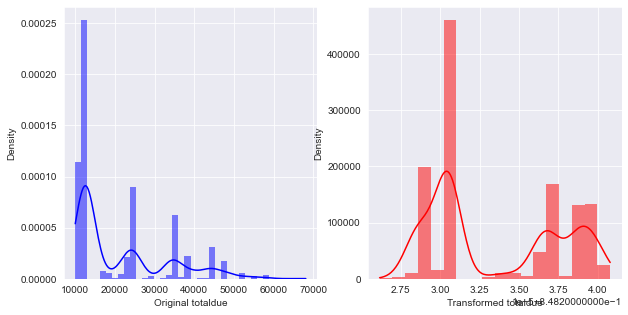


 ------------------------------------------------------

 'termdays' had 'positive' skewness of 1.88

 Transformation yielded skewness of 0.00


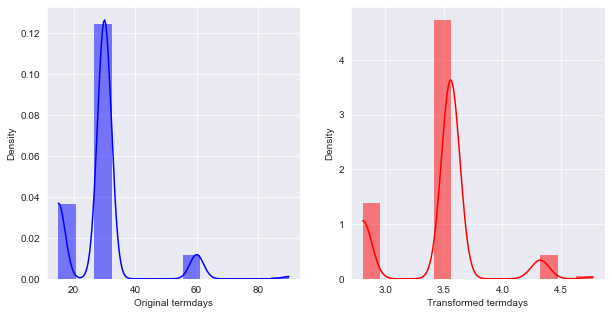


 ------------------------------------------------------

 'loannumber' had 'positive' skewness of 1.32

 Transformation yielded skewness of 0.12


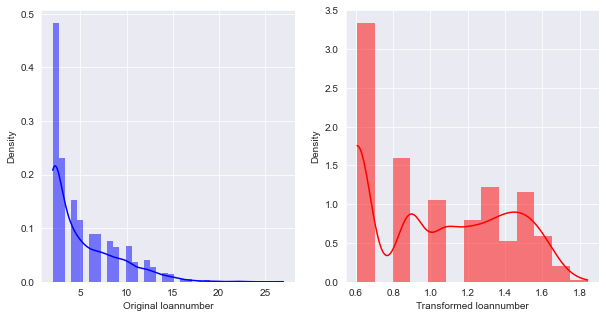


 ------------------------------------------------------

 'longitude_gps' had 'negative' skewness of -3.21

 Transformation yielded skewness of 5.73


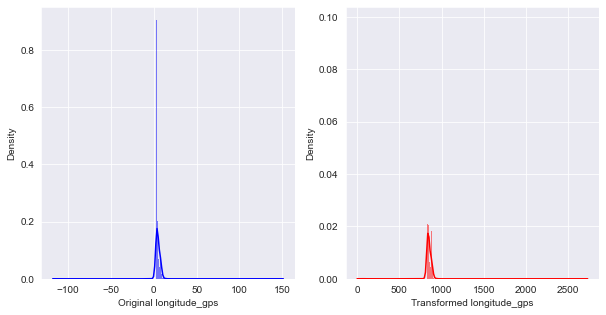


 ------------------------------------------------------

 'latitude_gps' had 'positive' skewness of 9.36

 Transformation yielded skewness of 4.14


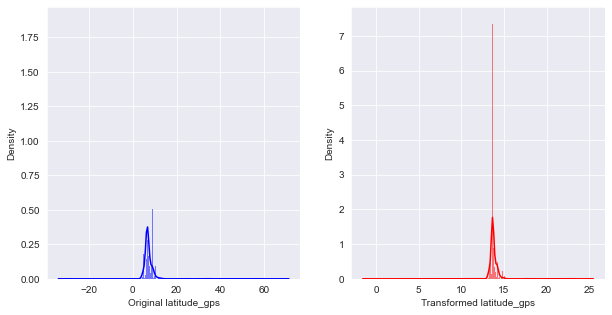


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'Age' . Skewness = 0.69


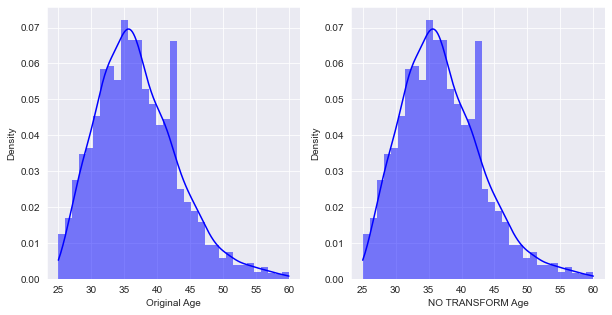

In [ ]:
# Use code above (adapted from https://github.com/datamadness/Automatic-skewness-transformation-for-Pandas-DataFrame) to correct skewness
# All the predictors are real-valued, so we can push them all through the skewness check/correction.
X = skew_autotransform(X.copy(deep=True), plot = True, exp = False, threshold = 1)

#**Pre-processing - Outliers**

In [ ]:
# Tukey Rule outliers
# As an alternative, you could use z-scores greater than 3 or less than -3.

cols = X.columns
#Tukey's method
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# Identify outliers
for i in cols:
  outliers_Tukey = tukey_rule(X,i)
  print("Column ",i,": ",outliers_Tukey)
  
# Windsorize X and check the results
print("Before", X.describe())
X_winsorized = X.copy(deep=True)
for i in cols:
  X_winsorized[i] = winsorize(X[i], limits=(0.05, 0.05))
print("After", X_winsorized.describe())





Column  loanamount :  []
Column  totaldue :  []
Column  termdays :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 2

In [ ]:
#Review columns
result.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'good_bad_flag',
       'longitude_gps', 'latitude_gps', 'Age', 'Location_Cluster',
       'referredby_No', 'referredby_Yes', 'bank_name_clients_First Bank',
       'bank_name_clients_GT Bank', 'bank_name_clients_OTHER',
       'employment_status_clients_OTHER',
       'employment_status_clients_Permanent',
       'employment_status_clients_Self-Employed',
       'employment_status_clients_Student', 'bank_account_type_Current',
       'bank_account_type_Other', 'bank_account_type_Savings',
       'level_of_education_clients_Graduate',
       'level_of_education_clients_Post-Graduate',
       'level_of_education_clients_Primary',
       'level_of_education_clients_Secondary'],
      dtype='object')

In [ ]:
X = result.drop(['good_bad_flag'], axis=1)
y = result['good_bad_flag']

(3269, 24)

In [ ]:
# split train and test data manually

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training Data Predictors\n',X_train.head(), '\nTraining Data Target\n',y_train.head(),'\n')
print('Test Data Predictors\n',X_test.head(), '\nTest Data Target\n',y_test.head())

Training Data Predictors
       loannumber  loanamount  totaldue  termdays  longitude_gps  latitude_gps  \
1742           2     10000.0   13000.0        30       3.376556      6.532273   
792            2     10000.0   11500.0        15       3.415634      6.436455   
2968           5     20000.0   24500.0        30       3.439571      6.434552   
1025           2     10000.0   13000.0        30       3.371536      6.441382   
1028           3     10000.0   11500.0        15       7.919752      5.043243   

      Age  Location_Cluster  referredby_No  referredby_Yes  ...  \
1742   27                 3              1               0  ...   
792    49                 3              1               0  ...   
2968   34                 3              1               0  ...   
1025   32                 3              1               0  ...   
1028   32                 2              1               0  ...   

      employment_status_clients_Permanent  \
1742                                   

In [ ]:
# Standardization of predictor
stdsc = StandardScaler()  
X_train_std = stdsc.fit_transform(X_train)   
X_test_std = stdsc.transform(X_test)            # transform uses the parameters from scaling the training data to transform our test data

In [ ]:
# Classifier decision regions on unbalanced holdout sample
names = ["Perceptron", "Logistic Regression", "SVM (RBF kernel)", "Decision Tree", "Naive Bayes", "k Nearest Neighbors", "MLP", "Random Forest", "XG Boost", "Light GBM"]

classifiers = [
    Perceptron(random_state=1),    
    LogisticRegression(),   
    SVC(kernel="rbf", C=1),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    KNeighborsClassifier(3),
    MLPClassifier(hidden_layer_sizes=(50,50),alpha=1, max_iter=1000),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50, learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

In [ ]:
# we use precision as the metric, and apply this metric to train and test data to find out the best classifier
# logistic is the best

for name, clf in zip(names, classifiers):
  # Pipeline
  estimators = []
  estimators.append(('standardize', StandardScaler()))
  estimators.append(('classifier',clf))
  model = Pipeline(estimators)
  # Eval Pipeline
  kfold_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)
  scoring = ['accuracy','balanced_accuracy','precision','recall','f1','roc_auc']
  for sc in scoring:
    results = cross_val_score(model, X=X, y=y, cv=kfold_cv, scoring=sc)
    print('Classifier: %s Metric %s mean (std deviation): %.3f (%.3f)' % (name, sc, results.mean(), results.std()))
  print('\n')
  print('Classifier: %s Metric precision mean (std deviation): %.3f (%.3f)' % (name, results.mean(), results.std()))
  print('\n')

Classifier: Perceptron Metric accuracy mean (std deviation): 0.650 (0.040)
Classifier: Perceptron Metric balanced_accuracy mean (std deviation): 0.495 (0.029)
Classifier: Perceptron Metric precision mean (std deviation): 0.780 (0.013)
Classifier: Perceptron Metric recall mean (std deviation): 0.769 (0.065)
Classifier: Perceptron Metric f1 mean (std deviation): 0.773 (0.034)
Classifier: Perceptron Metric roc_auc mean (std deviation): 0.491 (0.042)


Classifier: Perceptron Metric precision mean (std deviation): 0.491 (0.042)


Classifier: Logistic Regression Metric accuracy mean (std deviation): 0.781 (0.002)
Classifier: Logistic Regression Metric balanced_accuracy mean (std deviation): 0.500 (0.001)
Classifier: Logistic Regression Metric precision mean (std deviation): 0.782 (0.001)
Classifier: Logistic Regression Metric recall mean (std deviation): 0.998 (0.002)
Classifier: Logistic Regression Metric f1 mean (std deviation): 0.877 (0.001)
Classifier: Logistic Regression Metric roc_auc 

C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[16:36:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier: XG Boost Metric accuracy mean (std deviation): 0.781 (0.003)
[16:36:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classifier: XG Boost Metric balanced_accuracy mean (std deviation): 0.506 (0.003)
[16:36:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier: XG Boost Metric precision mean (std deviation): 0.784 (0.001)
[16:36:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier: XG Boost Metric recall mean (std deviation): 0.994 (0.003)
[16:36:05] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:06] WARNING: D:\bld\xgboost-split_1645118015404\work\sr

C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

[16:36:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier: XG Boost Metric f1 mean (std deviation): 0.877 (0.002)
[16:36:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:36:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:36:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classifier: XG Boost Metric roc_auc mean (std deviation): 0.609 (0.008)


Classifier: XG Boost Metric precision mean (std deviation): 0.609 (0.008)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fr

In [ ]:
# we use precision as the metric, and apply this metric to K-fold data to find out the best classifier
# KNN and XGboost are the best

# Classifier decision regions on unbalanced holdout sample
names = ["Perceptron", "Logistic Regression", "SVM (RBF kernel)", "Decision Tree", "Naive Bayes", "k Nearest Neighbors", "MLP", "Random Forest", "XG Boost", "Light GBM"]

classifiers = [
    Perceptron(random_state=1),    
    LogisticRegression(),   
    SVC(kernel="rbf", C=1),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    KNeighborsClassifier(3),
    MLPClassifier(hidden_layer_sizes=(50,50),alpha=1, max_iter=1000),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50, learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

no_folds = 5 # number of folds desired for cross validation
kf = StratifiedKFold(n_splits=no_folds, shuffle=True, random_state=12345)
for name, clf in zip(names, classifiers):
  print('CLASSIFIER: ',name,'\n')
  mean_accuracy = 0.0
  mean_balanced_accuracy = 0.0
  mean_auc = 0.0
  mean_precision = 0.0
  for fold, (train_index, test_index) in enumerate(kf.split(X,y),1):
    X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)] 
    sm = SMOTE()
    X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
    stdsc = StandardScaler()  
    X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)   
    X_test_std = stdsc.transform(X_test)   
    clf.fit(X_train_SMOTE_std, y_train_SMOTE) 
    y_pred = clf.predict(X_test_std)
    print(f'For fold {fold}:')
    print(f'precision: {precision_score(y_test, y_pred)}')
    mean_balanced_accuracy = mean_balanced_accuracy + balanced_accuracy_score(y_test, y_pred)
    mean_auc = mean_auc + roc_auc_score(y_test, y_pred)
    mean_precision = mean_precision + precision_score(y_test, y_pred)
  mean_precision = mean_precision / no_folds
  print('Average precision: %.3f' % (mean_precision))

CLASSIFIER:  Perceptron 

For fold 1:
precision: 0.7946257197696737
For fold 2:
precision: 0.7946859903381642
For fold 3:
precision: 0.7973568281938326
For fold 4:
precision: 0.8111111111111111
For fold 5:
precision: 0.8389057750759878
Average precision: 0.807
CLASSIFIER:  Logistic Regression 

For fold 1:
precision: 0.7822085889570553
For fold 2:
precision: 0.7919354838709678
For fold 3:
precision: 0.78125
For fold 4:
precision: 0.7934959349593496
For fold 5:
precision: 0.7895569620253164
Average precision: 0.788
CLASSIFIER:  SVM (RBF kernel) 

For fold 1:
precision: 0.7912087912087912
For fold 2:
precision: 0.7893030794165316
For fold 3:
precision: 0.7816455696202531
For fold 4:
precision: 0.7822706065318819
For fold 5:
precision: 0.7902208201892744
Average precision: 0.787
CLASSIFIER:  Decision Tree 

For fold 1:
precision: 0.8194070080862533
For fold 2:
precision: 0.8071748878923767
For fold 3:
precision: 0.8012820512820513
For fold 4:
precision: 0.8043478260869565
For fold 5:
prec

C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For fold 1:
precision: 0.7992957746478874
[16:33:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For fold 2:
precision: 0.7865961199294532
[16:33:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For fold 3:
precision: 0.78839590443686
[16:33:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For fold 4:
precision: 0.7906574394463668
[16:33:52] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For fold 5:
precision: 0.8014184397163121
Average precision: 0.793
CLASSIFIER:  Light GBM 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
For fold 1:
precision: 0.7909407665505227
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
For fold 2:
precision: 0.7889733840304183
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
For fold 3:
precision: 0.7814113597246127
[LightGBM] [Warning] feature_fraction is set=0.9, colsample

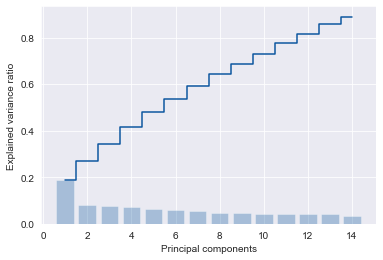

In [ ]:
# apply PCA on train_data to get important features --not working

from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_train_SMOTE)
pca.explained_variance_ratio_

# Show the explained variance ratio in order for each components
plt.bar(range(1, 15), pca.explained_variance_ratio_[:14], alpha=0.3, align='center')
plt.step(range(1, 15), np.cumsum(pca.explained_variance_ratio_[:14]), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

X_pca = pd.DataFrame(X_pca)

# the first is important, but others also have some explainatory power

In [ ]:
# apply RFE on train_data to get important features

from sklearn.feature_selection import RFE

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
_ = rfe.fit(X_train_std, y_train)
print('Important Features\n',X.columns[rfe.support_])

Important Features
 Index(['loannumber', 'loanamount', 'totaldue', 'longitude_gps', 'latitude_gps',
       'Age', 'referredby_No', 'bank_name_clients_GT Bank',
       'bank_name_clients_OTHER', 'employment_status_clients_Permanent'],
      dtype='object')


In [ ]:
# we use precision as the metric, and apply this metric to K-fold data and [selected features] to find out the best classifier
# KNN and XGboost are the best

# Classifier decision regions on unbalanced holdout sample
names = ["Perceptron", "Logistic Regression", "SVM (RBF kernel)", "Decision Tree", "Naive Bayes", "k Nearest Neighbors", "MLP", "Random Forest", "XG Boost", "Light GBM"]

classifiers = [
    Perceptron(random_state=1),    
    LogisticRegression(),   
    SVC(kernel="rbf", C=1),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    KNeighborsClassifier(3),
    MLPClassifier(hidden_layer_sizes=(50,50),alpha=1, max_iter=1000),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3),
    LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50, learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)]

X_selected = X[['loannumber', 'loanamount', 'totaldue', 'longitude_gps', 'latitude_gps',
       'Age', 'referredby_No', 'bank_name_clients_GT Bank',
       'bank_name_clients_OTHER', 'employment_status_clients_Permanent']]

no_folds = 5 # number of folds desired for cross validation
kf = StratifiedKFold(n_splits=no_folds, shuffle=True, random_state=12345)
for name, clf in zip(names, classifiers):
  print('CLASSIFIER: ',name,'\n')
  mean_accuracy = 0.0
  mean_balanced_accuracy = 0.0
  mean_auc = 0.0
  mean_precision = 0.0
  for fold, (train_index, test_index) in enumerate(kf.split(X_selected,y),1):
    X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)] 
    sm = SMOTE()
    X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train, y_train)
    stdsc = StandardScaler()  
    X_train_SMOTE_std = stdsc.fit_transform(X_train_SMOTE)   
    X_test_std = stdsc.transform(X_test)   
    clf.fit(X_train_SMOTE_std, y_train_SMOTE) 
    y_pred = clf.predict(X_test_std)
    print(f'For fold {fold}:')
    print(f'precision: {precision_score(y_test, y_pred)}')
    mean_balanced_accuracy = mean_balanced_accuracy + balanced_accuracy_score(y_test, y_pred)
    mean_auc = mean_auc + roc_auc_score(y_test, y_pred)
    mean_precision = mean_precision + precision_score(y_test, y_pred)
  mean_precision = mean_precision / no_folds
  print('Average precision: %.3f' % (mean_precision))

CLASSIFIER:  Perceptron 

For fold 1:
precision: 0.844574780058651
For fold 2:
precision: 0.7967806841046278
For fold 3:
precision: 0.7790697674418605
For fold 4:
precision: 0.7892644135188867
For fold 5:
precision: 0.788235294117647
Average precision: 0.800
CLASSIFIER:  Logistic Regression 

For fold 1:
precision: 0.7828746177370031
For fold 2:
precision: 0.7883683360258481
For fold 3:
precision: 0.785829307568438
For fold 4:
precision: 0.7911392405063291
For fold 5:
precision: 0.7889763779527559
Average precision: 0.787
CLASSIFIER:  SVM (RBF kernel) 

For fold 1:
precision: 0.7977883096366508
For fold 2:
precision: 0.7857142857142857
For fold 3:
precision: 0.7826771653543307
For fold 4:
precision: 0.7854785478547854
For fold 5:
precision: 0.7892234548335975
Average precision: 0.788
CLASSIFIER:  Decision Tree 

For fold 1:
precision: 0.8217270194986073
For fold 2:
precision: 0.806941431670282
For fold 3:
precision: 0.8097447795823666
For fold 4:
precision: 0.8189910979228486
For fold 

C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For fold 1:
precision: 0.8017543859649123
[16:42:42] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For fold 2:
precision: 0.7897526501766784
[16:42:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For fold 3:
precision: 0.7911714770797963
[16:42:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For fold 4:
precision: 0.7950089126559715
[16:42:43] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\bodhy\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


For fold 5:
precision: 0.8048780487804879
Average precision: 0.797
CLASSIFIER:  Light GBM 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
For fold 1:
precision: 0.798932384341637
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
For fold 2:
precision: 0.7890772128060264
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
For fold 3:
precision: 0.7850953206239168
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_

In [ ]:
# find the best KNN model hyper parameters using all features

model = imbpipeline([
        ('sample', SMOTE()),
        ('std', StandardScaler()),
        ('clf', KNeighborsClassifier())])

param_grid = {'clf__n_neighbors': [19, 21, 23],
              'clf__metric': ['minkowski', 'euclidean', 'manhattan']}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, scoring = 'average_precision')
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_estimator_)

# best n_neighbors is 21

{'clf__metric': 'minkowski', 'clf__n_neighbors': 21}
Pipeline(steps=[('sample', SMOTE()), ('std', StandardScaler()),
                ('clf', KNeighborsClassifier(n_neighbors=21))])


# BLUF:
- We used PCA and RFE to find the best predictors. RFE provides more useful insights
- using the filtered features, we split training and testing data with k-fold
- using presicion score as the key metric, we found the best classifiers are KNN and XGBoost
- using grid method, we found the best hyper parameters for KNN is minkowski distance and 21 neighbors